# Basal Inversion: HO Flowline (unsteady)

This notebook demonstrates how to invert for basal topography along a glacier flowline using observational data. In this example, two time-separated surfaces are used alongside measured SMB fields to model glacier dynamics without a steady-state assumption. We assume the observed surface elevation represents a steady-state profile governed by Blatter-Pattyn (Higher Order) Approximation.

The inversion follows the approach of [van Pelt et al. (2013)](https://tc.copernicus.org/articles/7/987/2013/), iteratively adjusting the bed to minimize the surface misfit after forward modeling. The procedure is implemented using the [centerflow_extruded](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow_extruded.ipynb) package, which is built on top of Firedrake and icepack. 

Begin by choosing a glacier:

In [1]:
name = 'Luggye' #choose your glacier from the list below, or add another

## Glacier identification

Hard coding IDs for Bechung, Thorthormi, Rahpstreng, and Luggye. For other glaciers, it will be necessary to find their RGIIDs from v. 7.

In [2]:
glaciers = {
    'Luggye': {
        'name': 'Luggye',
        'rgiid_7': '15-09534',
    },
    'Raphstreng': {
        'name': 'Raphstreng',
        'rgiid_7': '15-09531',
    },
    'Thorthormi': {
        'name': 'Thorthormi',
        'rgiid_7': '15-09532',
    },
    'Bechung': {
        'name': 'Bechung',
        'rgiid_7': '15-09530',
    }
}

## Imports

In [3]:
from firedrake import *
import icepack
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import pandas as pd
import tqdm

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow_extruded import *

## Paths

In [4]:
rgiid_7 = glaciers[name]['rgiid_7']
base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
outline6_path = base_path + 'outlines/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'

rgiid_6 = rgi6_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path, rgi6_path = outline6_path)
latlon = latlon_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path)

velocity_path = base_path + f'velocity/{rgiid_7}/MedianVelocity_2006.tif'
thickness_path = base_path + f'thickness/farinotti_ensemble/RGI60-{rgiid_6}_thickness.tif'
smb_path = base_path + 'smb/dussailant/ASE_gla_MEAN-CAL-mass-change-series_obs_unobs.csv'
# smb_path = base_path + 'smb/karma/prf_glacier_ctl.csv'

dem_path = base_path + f'elevation/farinotti/surface_DEM_RGI60-{rgiid_6}.tif'
dem_year = 2017 #the year corresponding to the DEM (probably somewhat earlier than RGI6, which was released in 2017)
start_year, end_year = 2010, 2020

dhdt_path = base_path + f'elevation/elevation_change/{start_year}_2020_dhdt/{latlon}_{start_year}-01-01_2020-01-01_dhdt.tif'

## Load and adjust data

Because ```icepack``` assumes that the waterline is at sea level, things run more smoothly if we shift the dem downward so that 0 is lake level. Meanwhile, surface mass balance measurements are too negative to support much forward modeling, so these are shifted as well. Finally, higher-order model convergence struggles with bumpy data, so smoothing is performed on all input datasets, using ```smooth_extruded_function```, which is defined in [centerflow_extruded](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow_extruded.ipynb). 

In [5]:
n_cells = 100

mesh = centerline_mesh(rgiid = rgiid_7, centerline_path = centerline_path, outline_path = outline_path, n_cells = n_cells)
mesh = crop_mesh(mesh = mesh, data_path = dem_path)
cell_size = int(mesh.glacier_length/n_cells)
print(f'average cell size = {cell_size} m')

thickness = map_to_mesh(mesh = mesh, data_path = thickness_path)
dem = map_to_mesh(mesh = mesh, data_path = dem_path)

Q = dem.function_space() #function space for depth-invariant quantities
Q_flat = icepack.depth_average(dem).function_space()
V = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'GL', vdegree = 2) #function space for quantities which vary with depth
x, ζ = SpatialCoordinate(mesh.mesh) #ζ ranges from 0 (base) to 1 (surface)
X = mesh.X
coords_surface = mesh.surface_coords
coords_base = mesh.basal_coords


freeboard = 50
smoothing_params = {'window': 3*cell_size, 'mesh': mesh}

dem_adjusted = Function(Q).project(dem - dem.at(mesh.glacier_length, 1/2) + freeboard)
dem_adjusted = smooth_extruded_function(function = dem_adjusted, **smoothing_params)
thickness = smooth_extruded_function(function = thickness, **smoothing_params)

try:
    velocity = map_to_mesh(mesh = mesh, data_path = velocity_path, ice_free_value = 0)
    velocity = smooth_extruded_function(function = velocity, **smoothing_params)
    # velocity_shape = (1 - (1 - ζ)**4) #the vertical velocity profile follows this shape, assuming n = 3
    velocity_shape = 1e-10 #or just zero out the velocity?
    u_0 = Function(V).project(velocity_shape*velocity) #use this velocity for our boundary condition
except:
    velocity = Function(Q).project(Constant(1e-10))
    u_0 = Function(V).project(velocity)

dH_dt_unsmoothed = map_to_mesh(mesh = mesh, data_path = dhdt_path, ice_free_value = 0)
dH_dt = smooth_extruded_function(function = dH_dt_unsmoothed, window = mesh.glacier_length/4, mesh = mesh)
mean_dHdt  = float(assemble(dH_dt*dx)/mesh.glacier_length)

print('mean thinning rate:', mean_dHdt, 'meters per year')

average cell size = 85 m
Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_ensemble/RGI60-15.02373_thickness.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/farinotti/surface_DEM_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/velocity/15-09534/MedianVelocity_2006.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/elevation/elevation_change/2010_2020_dhdt/N28E090_2010-01-01_2020-01-01_dhdt.tif from EPSG:32646 to EPSG:4326
mean thinning rate: -0.48185493799388246 meters per year


## Initialize the flow model

Depending on basal topography and glacier thickness evolution, the glacier may at times become ungrounded. To account for this, we define a new basal friction function which decreases with proximity to flotation. For this notebook, we assume the lake has the density of seawater, allowing ```icepack.compute_surface``` to straightforwardly determine where the glacier begins floating. 

In [6]:
def basal_friction(**kwargs): #function to scale the basal friction by fraction above flotation
    H = kwargs['thickness']
    s = kwargs['surface']
    u = kwargs['velocity']
    C = kwargs['friction']

    b = s - H
    ϱ = icepack.constants.ice_density/icepack.constants.water_density 

    flotation_surface = (1 - ϱ)*H #given the current thickness, this is the hypothetical surface elevation which would float the shelf
    h_af = s - flotation_surface #height above flotation
    frac_af = firedrake.min_value(h_af/H, 1) #fraction above flotation, capped at unity
    
    return icepack.models.hybrid.bed_friction(velocity = u, friction = C*frac_af)

T = 273.15 - 5 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
C = Constant(0.1)

model_opts = {'dirichlet_ids': [1]}
flow_model = icepack.models.HybridModel(friction = basal_friction)
flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

Δt = 1/10
num_timesteps = int((end_year - start_year)/Δt)

## Initialize reference surfaces

In [7]:
s_1 = dem_adjusted.copy(deepcopy = True)
s_1.year = dem_year

s_0 = Function(Q).project(s_1 - dH_dt*(dem_year - start_year))
s_0.year = start_year

s_2 = Function(Q).project(s_1 + dH_dt*(end_year - dem_year))
s_2.year = end_year

## Initialize SMB data

SMB data consist of single glacier-averaged values at each timestep. The inversion performs poorly with data this coarse. We can create slightly more realistic data by assuming that SMB varies with elevation via some lapse rate, and we construct a spatially variable SMB field whose spatial average is the appropriate value. The lapse rate is chosen so that the spread in SMB values is similar to the spread in the observed thinning rate. 

In [8]:
df = pd.read_csv(smb_path)
row = df.loc[df["RGIId"] == f'RGI60-{rgiid_6}']

lapse_rate = 0.003 #obtained by trial and error

smb_expr = lapse_rate*dem_adjusted #SMB is of the form smb = a*elevation + b, where a is the lapse rate and b is to be determined
temp_mean = assemble(smb_expr*dx)/mesh.glacier_length #the spatial mean of the expression smb = a*elevation + 0, which will need correcting

smb_dict = {} #list of glacier-wide specific SMB values (one per year)
for step in range(num_timesteps):
    decimal_year = s_0.year + step*Δt
    int_year = s_0.year + int(step*Δt)
    smb_mean = float(row[str(int_year)].iloc[0])
    b = smb_mean - temp_mean #how far off is our guess?
    entry = Function(Q).project(smb_expr + b) #adjust by this much
    smb_dict[decimal_year] = entry

Text(0, 0.5, 'elevation change rate (m per year)')

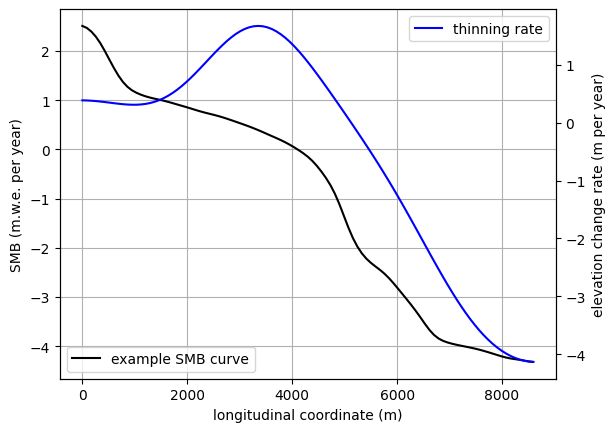

In [9]:
plt.figure()
plt.plot(X, icepack.depth_average(smb_dict[2017.0]).at(X, tolerance = 1e-10), color = 'k', label = 'example SMB curve')
plt.grid()
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('SMB (m.w.e. per year)')
plt.legend(loc = 'lower left')

plt.twinx()
plt.plot(X, icepack.depth_average(dH_dt).at(X, tolerance = 1e-10), color = 'blue', label = 'thinning rate')
plt.legend(loc = 'upper right')
plt.ylabel('elevation change rate (m per year)')

## Invert for basal topography

In [10]:
inversion_params = {
    'model': flow_model,
    'solver': flow_solver,
    'mesh': mesh,
    'fluidity': A,
    'friction': C,
    'surface': s_0,
    'surface_2': s_2
}
    
inversion = solve_bed(K = 0.1, num_iterations = 40, thickness_guess = Constant(200), velocity = u_0, accumulation = smb_dict, 
                      **inversion_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [02:23<00:00,  3.60s/it]


## Visualize the results

Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_model_1/thickness_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_model_2/thickness_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_model_3/thickness_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326
Reprojecting /eejit/home/bezu0001/data/thickness/farinotti_model_4/thickness_RGI60-15.02373.tif from EPSG:32646 to EPSG:4326


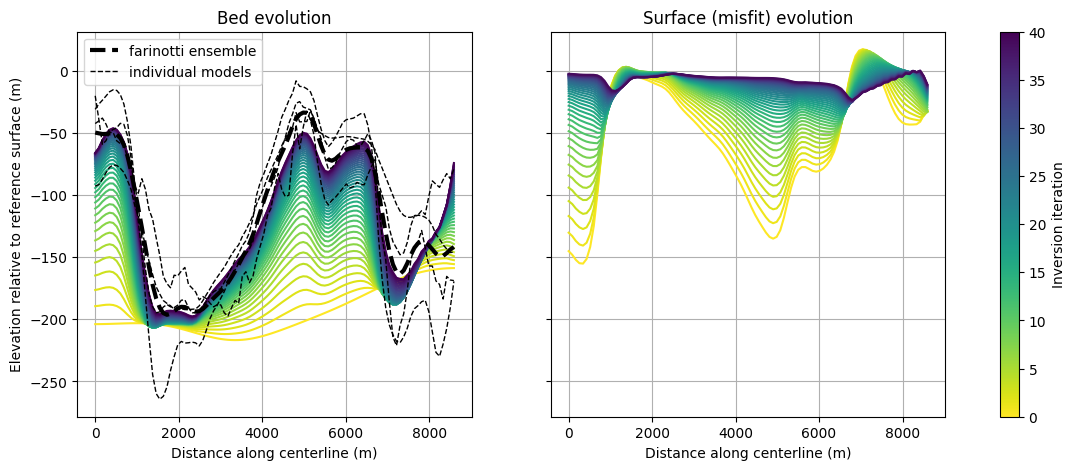

In [11]:
s_ref_array = inversion.s_ref.dat.data_ro.copy()
farinotti_ref_array = -thickness.dat.data_ro.copy()

thickness_1_path = base_path + f'thickness/farinotti_model_1/thickness_RGI60-{rgiid_6}.tif'
thickness_2_path = base_path + f'thickness/farinotti_model_2/thickness_RGI60-{rgiid_6}.tif'
thickness_3_path = base_path + f'thickness/farinotti_model_3/thickness_RGI60-{rgiid_6}.tif'
thickness_4_path = base_path + f'thickness/farinotti_model_4/thickness_RGI60-{rgiid_6}.tif'

farinotti_1 = -map_to_mesh(mesh = mesh, data_path = thickness_1_path).dat.data_ro.copy()
farinotti_2 = -map_to_mesh(mesh = mesh, data_path = thickness_2_path).dat.data_ro.copy()
farinotti_3 = -map_to_mesh(mesh = mesh, data_path = thickness_3_path).dat.data_ro.copy()
farinotti_4 = -map_to_mesh(mesh = mesh, data_path = thickness_4_path).dat.data_ro.copy()

# Evolution data
bed_evolution = inversion.bed_evolution
surface_evolution = inversion.surface_evolution

# Setup colormap
N = len(bed_evolution)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N - 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: Bed evolution
for i, entry in enumerate(bed_evolution):
    axes[0].plot(X, entry - s_ref_array, color=cmap(norm(i)))
axes[0].plot(X, farinotti_ref_array, color = 'k', linestyle = 'dashed', linewidth = 3, label = 'farinotti ensemble')
axes[0].plot(X, farinotti_1, color = 'k', linestyle = 'dashed', linewidth = 1, label = 'individual models')
axes[0].plot(X, farinotti_2, color = 'k', linestyle = 'dashed', linewidth = 1)
axes[0].plot(X, farinotti_3, color = 'k', linestyle = 'dashed', linewidth = 1)
axes[0].plot(X, farinotti_4, color = 'k', linestyle = 'dashed', linewidth = 1)
axes[0].set_title('Bed evolution')
axes[0].set_xlabel('Distance along centerline (m)')
axes[0].set_ylabel('Elevation relative to reference surface (m)')
axes[0].legend()
axes[0].grid()

# Right: Surface misfit evolution
for i, entry in enumerate(surface_evolution):
    axes[1].plot(X, entry - s_ref_array, color=cmap(norm(i)))
axes[1].set_title('Surface (misfit) evolution')
axes[1].set_xlabel('Distance along centerline (m)')
axes[1].grid()

# Shared colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', label='Inversion iteration')
plt.show()

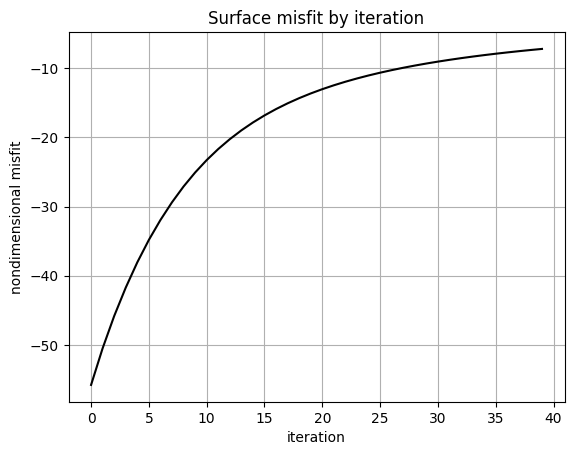

In [12]:
plt.figure()
plt.title('Surface misfit by iteration')
plt.plot(range(len(inversion.misfits)), inversion.misfits, color='k')
plt.ylabel('nondimensional misfit')
plt.xlabel('iteration')
plt.grid(True, which='both')
# plt.ylim(0) 
plt.show()

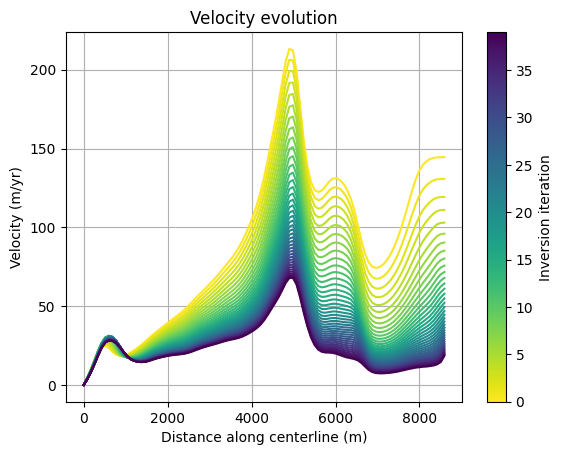

In [13]:
# Evolution data
velocity_evolution = inversion.velocity_evolution

# Setup colormap
N = len(velocity_evolution)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin = 0, vmax = N - 1)

fig, axes = plt.subplots()

# Left: Bed evolution
for i, entry in enumerate(velocity_evolution):
    plt.plot(X, entry, color = cmap(norm(i)))
plt.title('Velocity evolution')
plt.xlabel('Distance along centerline (m)')
plt.ylabel('Velocity (m/yr)')
plt.grid()

sm = ScalarMappable(norm = norm, cmap = cmap)
fig.colorbar(sm, ax = axes, orientation = 'vertical', label = 'Inversion iteration')
plt.show()

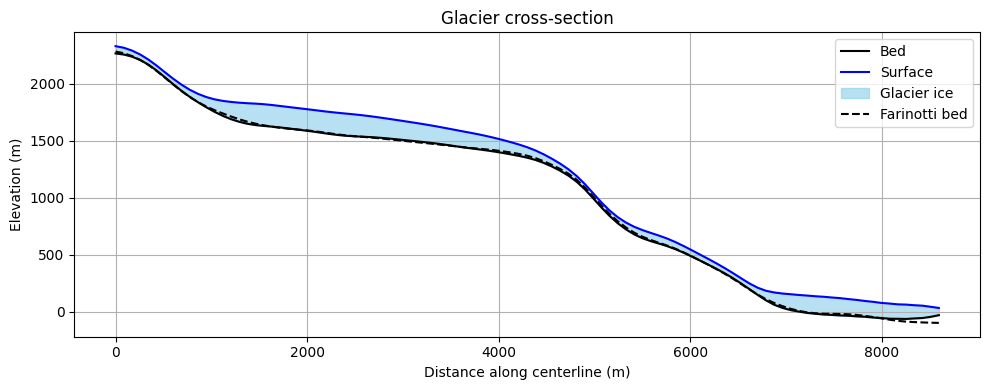

In [14]:
base = surface_evolution[-1] - inversion.thickness_evolution[-1]
surface = surface_evolution[-1]
bed = bed_evolution[-1]
farinotti_bed_array = s_ref_array + farinotti_ref_array


plt.figure(figsize = (10, 4))
plt.plot(X, bed, color = 'black', label = 'Bed')
plt.plot(X, surface, color = 'blue', label = 'Surface')
plt.fill_between(X, base, surface, color = 'skyblue', alpha = 0.6, label = 'Glacier ice')
plt.plot(X, farinotti_bed_array, color = 'k', linestyle = 'dashed', label = 'Farinotti bed')

plt.xlabel('Distance along centerline (m)')
plt.ylabel('Elevation (m)')
plt.title('Glacier cross-section')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()